In [2]:
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
from irrCAC.raw import CAC
import scipy.stats as stats
from sklearn.metrics import mean_squared_error


In [3]:
import warnings
warnings.filterwarnings("ignore")

## Compiling all the LLM scores

In [4]:
llama_scores = pd.read_excel('data/all_llama_ratings.xlsx')
gpt_scores = pd.read_excel('data/all_gpt4_ratings.xlsx')
mistral_scores = pd.read_excel('data/all_mistral_ratings.xlsx')
all_llm_scores = pd.merge(mistral_scores, gpt_scores, on=['id', 'conversation_id', 'proc_text'], how='inner')
all_llm_scores = pd.merge(all_llm_scores, llama_scores, on=['id', 'conversation_id'], how='inner')
all_llm_scores

,id,conversation_id,proc_text,mis_nonchat_int,mix_int,mis7_int,gpt4_int,gpt4o_int,7b_int,13b_int,7bnonchat_int,13bnonchat_int,llama3_chat_int,llama3_nonchat_int
0,45939,7,"teacher: hi there <student>, all ok? student:...",1.0,3,3.0,2.0,1,1.0,4.0,0,2,4,2.0
1,45940,7,"teacher: yeah i'm good thanks, just been for a...",3.0,3,3.0,3.0,2,3.0,4.0,1,2,3,0.0
2,45941,7,teacher: yeah? what did you do? i'll come back...,2.0,3,3.0,3.0,3,2.0,3.0,3,2,4,1.0
3,45942,7,teacher: ok i see ...too bad about the running...,2.0,3,4.0,3.0,4,3.0,4.0,3,4,3,3.0
4,45943,7,teacher: yes i realise it's not easy really! i...,2.0,3,3.0,3.0,2,4.0,4.0,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6651,56386,258,teacher: but 'to loan' means 'to lend' studen...,1.0,2,2.0,2.0,1,4.0,3.0,2,1,2,4.0
6652,56387,258,"teacher: banks loan money yes, exactly, it wou...",0.0,3,3.0,3.0,3,3.0,2.0,3,1,3,3.0
6653,56388,258,"teacher: ooh, we're out of time! student: or ...",4.0,2,0.0,2.0,2,4.0,3.0,3,0,1,2.0
6654,56389,258,"teacher: yes, absolutely! student: 13:59 on m...",2.0,1,0.0,2.0,1,4.0,NaN,3,2,0,3.0


In [5]:
human_ratings = pd.read_excel('data/all_llms_human.xlsx')
human_ratings.head()

,text,conversation_id,id,human_int_mean,human_int_var,58c62eac444ade00010231a9,59b536d60516f6000197c3f9,5ab15ab4c42b630001cd36fb,5ad63c167f70c10001904bc5,5b830542b0d72600018dc280,...,new_13bchat,new_7bchat,7b_int,13b_int,7bnonchat_int,13bnonchat_int,gpt4_int,mis_nonchat_int,mix_int,mis7_int
0,"teacher: hi there <student>, all ok? student:...",7,45939,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,1.0,4.0,0,2,2.0,1.0,3,3.0
1,"teacher: yeah i'm good thanks, just been for a...",7,45940,1.333333,0.333333,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,3.0,4.0,1,2,3.0,3.0,3,3.0
2,teacher: yeah? what did you do? i'll come back...,7,45941,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,2.0,3.0,3,2,3.0,2.0,3,3.0
3,teacher: ok i see ...too bad about the running...,7,45942,2.666667,0.333333,NaN,NaN,NaN,NaN,NaN,...,3.0,3.0,3.0,4.0,3,4,3.0,2.0,3,4.0
4,teacher: yes i realise it's not easy really! i...,7,45943,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,4.0,4.0,1,1,3.0,2.0,3,3.0


In [6]:
human_ratings_individuals  = human_ratings.iloc[:, :-14]
human_ratings_individuals

,text,conversation_id,id,human_int_mean,human_int_var,58c62eac444ade00010231a9,59b536d60516f6000197c3f9,5ab15ab4c42b630001cd36fb,5ad63c167f70c10001904bc5,5b830542b0d72600018dc280,...,61139bc8479c2861f52c4a71,611a78efa6c36a674dc40cc6,611a9f9591ef82d19cfc5db1,611ccab657532350bc9b78ee,612a87998958706392797405,613d091096ca434d703f77c5,614e848825ae648282115670,61693c754827d0e35885a4ea,6171b1bc917dfe828a3130dd,6341258618bd26e47d901d74
0,"teacher: hi there <student>, all ok? student:...",7,45939,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"teacher: yeah i'm good thanks, just been for a...",7,45940,1.333333,0.333333,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,teacher: yeah? what did you do? i'll come back...,7,45941,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,teacher: ok i see ...too bad about the running...,7,45942,2.666667,0.333333,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,teacher: yes i realise it's not easy really! i...,7,45943,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6651,teacher: but 'to loan' means 'to lend' studen...,258,56386,1.000000,0.000000,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6652,"teacher: banks loan money yes, exactly, it wou...",258,56387,1.333333,0.333333,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6653,"teacher: ooh, we're out of time! student: or ...",258,56388,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6654,"teacher: yes, absolutely! student: 13:59 on m...",258,56389,0.666667,0.333333,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
human_ratings_avg = human_ratings[[ 'conversation_id','id','human_int_mean','human_int_var']]
human_ratings_avg.head()

,conversation_id,id,human_int_mean,human_int_var
0,7,45939,1.000000,1.000000
1,7,45940,1.333333,0.333333
2,7,45941,2.000000,0.000000
3,7,45942,2.666667,0.333333
4,7,45943,2.000000,1.000000


In [8]:
all_human_llm = human_ratings_individuals.merge(all_llm_scores.drop(columns=['proc_text']), on=['conversation_id', 'id'])
all_human_llm

,text,conversation_id,id,human_int_mean,human_int_var,58c62eac444ade00010231a9,59b536d60516f6000197c3f9,5ab15ab4c42b630001cd36fb,5ad63c167f70c10001904bc5,5b830542b0d72600018dc280,...,mix_int,mis7_int,gpt4_int,gpt4o_int,7b_int,13b_int,7bnonchat_int,13bnonchat_int,llama3_chat_int,llama3_nonchat_int
0,"teacher: hi there <student>, all ok? student:...",7,45939,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,3,3.0,2.0,1,1.0,4.0,0,2,4,2.0
1,"teacher: yeah i'm good thanks, just been for a...",7,45940,1.333333,0.333333,NaN,NaN,NaN,NaN,NaN,...,3,3.0,3.0,2,3.0,4.0,1,2,3,0.0
2,teacher: yeah? what did you do? i'll come back...,7,45941,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,3,3.0,3.0,3,2.0,3.0,3,2,4,1.0
3,teacher: ok i see ...too bad about the running...,7,45942,2.666667,0.333333,NaN,NaN,NaN,NaN,NaN,...,3,4.0,3.0,4,3.0,4.0,3,4,3,3.0
4,teacher: yes i realise it's not easy really! i...,7,45943,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,3,3.0,3.0,2,4.0,4.0,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6651,teacher: but 'to loan' means 'to lend' studen...,258,56386,1.000000,0.000000,1.0,NaN,NaN,NaN,NaN,...,2,2.0,2.0,1,4.0,3.0,2,1,2,4.0
6652,"teacher: banks loan money yes, exactly, it wou...",258,56387,1.333333,0.333333,1.0,NaN,NaN,NaN,NaN,...,3,3.0,3.0,3,3.0,2.0,3,1,3,3.0
6653,"teacher: ooh, we're out of time! student: or ...",258,56388,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,...,2,0.0,2.0,2,4.0,3.0,3,0,1,2.0
6654,"teacher: yes, absolutely! student: 13:59 on m...",258,56389,0.666667,0.333333,0.0,NaN,NaN,NaN,NaN,...,1,0.0,2.0,1,4.0,NaN,3,2,0,3.0


In [9]:
all_human_llm.to_excel('data/combined_human_individual_all_llm_ratings.xlsx', index=False)

## Human and LLM Comparision (AC2 scores) 

In [10]:

MY_WEIGHT_MATRIX = np.array([[1., 0.8, 0.35, 0., 0.],
                            [0.9, 1., 0.7, 0.1, 0.],
                            [0., 0.6, 1., 0.6, 0.],
                            [0., 0.1, 0.7, 1., 0.9],
                            [0., 0., 0.35, 0.8, 1.]])


def find_mean_ac2(data_df, int_col, participants):
    ac2_scores = []

    for p in participants:
        #print(p)
        part_df = data_df[[p,int_col]].dropna()
        if len(part_df!=0):
            ac2 = CAC(part_df, categories=[0,1,2,3,4], weights=MY_WEIGHT_MATRIX).gwet()['est']['coefficient_value']
            ac2_scores.append(ac2)
    return np.mean(ac2_scores)


In [11]:
all_human_llm.columns[-11:]

Index(['mis_nonchat_int', 'mix_int', 'mis7_int', 'gpt4_int', 'gpt4o_int',
       '7b_int', '13b_int', '7bnonchat_int', '13bnonchat_int',
       'llama3_chat_int', 'llama3_nonchat_int'],
      dtype='object')

In [12]:
participants = all_human_llm.columns[5:-11]
print('LLAMA 3 chat :', find_mean_ac2(all_human_llm, 'llama3_chat_int', participants))
print('LLAMA 3 non chat :', find_mean_ac2(all_human_llm, 'llama3_nonchat_int', participants))
print('LLAMA 2 7b chat :', find_mean_ac2(all_human_llm, '7b_int', participants))
print('LLAMA 2 7b non chat :', find_mean_ac2(all_human_llm, '7bnonchat_int', participants))
print('LLAMA 2 13b chat :', find_mean_ac2(all_human_llm, '13b_int', participants))
print('LLAMA 2 13b non chat :', find_mean_ac2(all_human_llm, '13bnonchat_int', participants))
print('GPT 4 chat :', find_mean_ac2(all_human_llm, 'gpt4_int', participants))
print('GPT 4o chat :', find_mean_ac2(all_human_llm, 'gpt4o_int', participants))
print('Mixtral instruct :', find_mean_ac2(all_human_llm, 'mix_int', participants))
print('Mistral chat :', find_mean_ac2(all_human_llm, 'mis7_int', participants))
print('Mistral non chat :', find_mean_ac2(all_human_llm, 'mis_nonchat_int', participants))


LLAMA 3 chat : 0.2745986458333333
LLAMA 3 non chat : 0.17858552083333334
LLAMA 2 7b chat : 0.20975135416666668
LLAMA 2 7b non chat : 0.06172197916666666
LLAMA 2 13b chat : 0.19935958333333334
LLAMA 2 13b non chat : 0.2910790625
GPT 4 chat : 0.3441986458333333
GPT 4o chat : 0.3832785416666667
Mixtral instruct : 0.3700513541666666
Mistral chat : 0.26872541666666666
Mistral non chat : 0.13724104166666667


## Gispy (Concreteness and Imagery) Analysis

In [13]:
gispy_results = pd.read_csv('data/rerun_gispy_output.csv') ## new gispy computed
gispy_results['conversation_id'] = gispy_results['d_id'].apply(lambda x: int(x.split('_')[0]))
gispy_results['id'] = gispy_results['d_id'].apply(lambda x: int(x.split('_')[1][:-4]))
gispy_results.head()

,d_id,text,DESPC,DESSC,CoREF,PCREF_1,PCREF_a,PCREF_1p,PCREF_ap,PCDC,...,zSMCAUSwn_1_binary,zSMCAUSwn_a_binary,zPCCNC_megahr,zWRDIMGc_megahr,zPCCNC_mrc,zWRDIMGc_mrc,zWRDHYPnv,gis,conversation_id,id
0,007_45939.txt,"teacher: hi there <student>, all ok? student: ...",1,2,0,0.892097,0.892097,0.892097,0.892097,0.0,...,-0.448102,-0.512201,1.190982,1.238249,1.325901,1.323961,2.369201,-2.447473,7,45939
1,007_45940.txt,"teacher: yeah i'm good thanks, just been for a...",1,3,0,0.376081,0.302116,0.376081,0.302116,0.0,...,-0.448102,-0.512201,-0.567519,-0.290569,0.597127,0.463004,-0.606726,1.963340,7,45940
2,007_45941.txt,teacher: yeah? what did you do? i'll come back...,1,7,0,0.220715,0.199812,0.220715,0.199812,0.0,...,-0.088087,-0.273174,-0.355812,-0.295017,-0.324301,-0.237484,-1.000376,2.118316,7,45941
3,007_45942.txt,teacher: ok i see ...too bad about the running...,1,6,0,0.158609,0.203566,0.158609,0.203566,0.0,...,-0.448102,0.153660,-0.946630,-0.648479,-0.045645,-0.090008,-1.265741,2.944282,7,45942
4,007_45943.txt,teacher: yes i realise it's not easy really! i...,1,3,0,0.173712,0.184732,0.173712,0.184732,0.0,...,0.991960,0.264637,-1.557402,-1.391983,-0.800352,-0.765104,-0.616511,3.711383,7,45943


In [14]:
conc_computed = pd.read_excel('data/concreteness_imagery_computed.xlsx')
conc_computed.sort_values(['conversation_id','id'])

,proc_text,conversation_id,id,int_mean,int_var,conv_words,tot_conv_words,conv_len,concreteness_tot_conv,imagery_tot_conv
28,"hi there <student>, all ok? hi <teacher>, how ...",7,45939,1.000000,1.000000,"['hi', 'there', 'student', 'all', 'ok', 'hi', ...","['hi', 'there', 'student', 'all', 'ok', 'hi', ...",10,2.581713,2.958759
35,"yeah i'm good thanks, just been for a run! tha...",7,45940,1.333333,0.333333,"['yeah', 'i', 'm', 'good', 'thanks', 'just', '...","['yeah', 'i', 'm', 'good', 'thanks', 'just', '...",31,2.276253,2.645196
3,yeah? what did you do? i'll come back on the h...,7,45941,2.000000,0.000000,"['yeah', 'what', 'did', 'you', 'do', 'i', 'll'...","['yeah', 'what', 'did', 'you', 'do', 'i', 'll'...",114,2.585220,2.953317
63,ok i see ...too bad about the running...but yo...,7,45942,2.666667,0.333333,"['ok', 'i', 'see', 'too', 'bad', 'about', 'the...","['ok', 'i', 'see', 'too', 'bad', 'about', 'the...",120,2.537183,2.950318
11,yes i realise it's not easy really! i can see ...,7,45943,2.000000,1.000000,"['yes', 'i', 'realise', 'it', 's', 'not', 'eas...","['yes', 'i', 'realise', 'it', 's', 'not', 'eas...",56,2.346176,2.754570
...,...,...,...,...,...,...,...,...,...,...
6645,but 'to loan' means 'to lend' (i hope i'm not ...,258,56386,1.000000,0.000000,"['but', 'to', 'loan', 'means', 'to', 'lend', '...","['but', 'to', 'loan', 'means', 'to', 'lend', '...",18,2.498470,2.902686
6620,"banks loan money yes, exactly, it would be cle...",258,56387,1.333333,0.333333,"['banks', 'loan', 'money', 'yes', 'exactly', '...","['banks', 'loan', 'money', 'yes', 'exactly', '...",62,2.858817,3.247250
6622,"ooh, we're out of time! or maybe with money/in...",258,56388,1.000000,1.000000,"['ooh', 'we', 're', 'out', 'of', 'time', 'or',...","['ooh', 'we', 're', 'out', 'of', 'time', 'or',...",20,2.958907,3.406845
6630,"yes, absolutely! 13:59 on my laptop i am using...",258,56389,0.666667,0.333333,"['yes', 'absolutely', '13', '59', 'on', 'my', ...","['yes', 'absolutely', '13', '59', 'on', 'my', ...",15,2.323969,2.582139


In [15]:


corr = conc_computed[['int_mean','int_var','concreteness_tot_conv', 'imagery_tot_conv']].corr(method='kendall')
corr.style.background_gradient(cmap='coolwarm')

,int_mean,int_var,concreteness_tot_conv,imagery_tot_conv
int_mean,1.000000,-0.002320,0.010347,0.007593
int_var,-0.002320,1.000000,0.009531,0.010767
concreteness_tot_conv,0.010347,0.009531,1.000000,0.881200
imagery_tot_conv,0.007593,0.010767,0.881200,1.000000


In [16]:
gispy_merged = human_ratings_avg.merge(gispy_results, on=['id','conversation_id'], how='left', indicator=True)
gispy_merged

,conversation_id,id,human_int_mean,human_int_var,d_id,text,DESPC,DESSC,CoREF,PCREF_1,...,zSMCAUSwn_ap_binary,zSMCAUSwn_1_binary,zSMCAUSwn_a_binary,zPCCNC_megahr,zWRDIMGc_megahr,zPCCNC_mrc,zWRDIMGc_mrc,zWRDHYPnv,gis,_merge
0,7,45939,1.000000,1.000000,007_45939.txt,"teacher: hi there <student>, all ok? student: ...",1,2,0,0.892097,...,-0.512201,-0.448102,-0.512201,1.190982,1.238249,1.325901,1.323961,2.369201,-2.447473,both
1,7,45940,1.333333,0.333333,007_45940.txt,"teacher: yeah i'm good thanks, just been for a...",1,3,0,0.376081,...,-0.512201,-0.448102,-0.512201,-0.567519,-0.290569,0.597127,0.463004,-0.606726,1.963340,both
2,7,45941,2.000000,0.000000,007_45941.txt,teacher: yeah? what did you do? i'll come back...,1,7,0,0.220715,...,-0.273174,-0.088087,-0.273174,-0.355812,-0.295017,-0.324301,-0.237484,-1.000376,2.118316,both
3,7,45942,2.666667,0.333333,007_45942.txt,teacher: ok i see ...too bad about the running...,1,6,0,0.158609,...,0.153660,-0.448102,0.153660,-0.946630,-0.648479,-0.045645,-0.090008,-1.265741,2.944282,both
4,7,45943,2.000000,1.000000,007_45943.txt,teacher: yes i realise it's not easy really! i...,1,3,0,0.173712,...,0.264637,0.991960,0.264637,-1.557402,-1.391983,-0.800352,-0.765104,-0.616511,3.711383,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6651,258,56386,1.000000,0.000000,258_56386.txt,teacher: but 'to loan' means 'to lend' student...,1,1,0,0.000000,...,-0.046098,-0.448102,-0.046098,-0.631654,-0.587625,0.717232,0.968698,-0.131329,-1.219117,both
6652,258,56387,1.333333,0.333333,258_56387.txt,"teacher: banks loan money yes, exactly, it wou...",1,5,0,0.278443,...,-0.290247,-0.448102,-0.290247,-0.794932,-1.097238,-0.983633,-1.052776,-0.990920,3.425822,both
6653,258,56388,1.000000,1.000000,258_56388.txt,"teacher: ooh, we're out of time! student: or m...",1,3,0,0.399370,...,-0.512201,-0.448102,-0.512201,-0.968940,-1.218654,0.263789,0.757216,-0.349496,2.034560,both
6654,258,56389,0.666667,0.333333,258_56389.txt,"teacher: yes, absolutely! student: 13:59 on my...",1,2,0,0.247527,...,-0.512201,-0.448102,-0.512201,1.982355,1.937691,0.347404,0.170700,0.556737,-5.344408,both


In [17]:
corr2 = gispy_merged.drop(columns=['d_id', 'text', 'conversation_id', 'id', '_merge','DESPC', 'DESSC','zDESPC', 'zDESSC']).corr(method='kendall')
corr2_clean = corr2.dropna(how='all', axis=0).dropna(how='all', axis=1)
# Mask the upper triangle
mask = np.triu(np.ones_like(corr2_clean, dtype=bool))

# Apply the mask to the correlation matrix and style it
corr2_clean_masked = corr2_clean.mask(mask)

# Style the correlation matrix with a background gradient
corr2_clean_masked.style.background_gradient(cmap='coolwarm')

,human_int_mean,human_int_var,CoREF,PCREF_1,PCREF_a,PCREF_1p,PCREF_ap,PCDC,SMCAUSe_1,SMCAUSe_a,SMCAUSe_1p,SMCAUSe_ap,SMCAUSwn_1p_path,SMCAUSwn_1p_lch,SMCAUSwn_1p_wup,SMCAUSwn_ap_path,SMCAUSwn_ap_lch,SMCAUSwn_ap_wup,SMCAUSwn_1_path,SMCAUSwn_1_lch,SMCAUSwn_1_wup,SMCAUSwn_a_path,SMCAUSwn_a_lch,SMCAUSwn_a_wup,SMCAUSwn_1p_binary,SMCAUSwn_ap_binary,SMCAUSwn_1_binary,SMCAUSwn_a_binary,PCCNC_megahr,WRDIMGc_megahr,PCCNC_mrc,WRDIMGc_mrc,WRDHYPnv,zPCREF_1,zPCREF_a,zPCREF_1p,zPCREF_ap,zPCDC,zSMCAUSe_1,zSMCAUSe_a,zSMCAUSe_1p,zSMCAUSe_ap,zSMCAUSwn_1p_path,zSMCAUSwn_1p_lch,zSMCAUSwn_1p_wup,zSMCAUSwn_ap_path,zSMCAUSwn_ap_lch,zSMCAUSwn_ap_wup,zSMCAUSwn_1_path,zSMCAUSwn_1_lch,zSMCAUSwn_1_wup,zSMCAUSwn_a_path,zSMCAUSwn_a_lch,zSMCAUSwn_a_wup,zSMCAUSwn_1p_binary,zSMCAUSwn_ap_binary,zSMCAUSwn_1_binary,zSMCAUSwn_a_binary,zPCCNC_megahr,zWRDIMGc_megahr,zPCCNC_mrc,zWRDIMGc_mrc,zWRDHYPnv,gis
human_int_mean,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
human_int_var,0.000098,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CoREF,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PCREF_1,0.095808,-0.002398,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PCREF_a,0.087327,0.004982,nan,0.823663,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PCREF_1p,0.095808,-0.002398,nan,1.000000,0.823663,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PCREF_ap,0.087327,0.004982,nan,0.823663,1.000000,0.823663,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PCDC,0.071996,-0.001215,nan,0.019954,0.008016,0.019954,0.008016,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
SMCAUSe_1,0.134689,0.006130,nan,0.051097,0.046150,0.051097,0.046150,0.066842,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
SMCAUSe_a,0.135311,0.001448,nan,0.064375,0.062629,0.064375,0.062629,0.057029,0.821399,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [18]:
pivoted_df = all_human_llm.melt(id_vars=["text", "conversation_id", "id", "human_int_mean", "human_int_var",'mis_nonchat_int',
                                         'mix_int', 'mis7_int', 'gpt4_int', 'gpt4o_int', '7b_int', '13b_int', '7bnonchat_int', '13bnonchat_int', 'llama3_chat_int', 'llama3_nonchat_int'], 
                     var_name="Participant", 
                     value_name="value")

pivoted_df

,text,conversation_id,id,human_int_mean,human_int_var,mis_nonchat_int,mix_int,mis7_int,gpt4_int,gpt4o_int,7b_int,13b_int,7bnonchat_int,13bnonchat_int,llama3_chat_int,llama3_nonchat_int,Participant,value
0,"teacher: hi there <student>, all ok? student:...",7,45939,1.000000,1.000000,1.0,3,3.0,2.0,1,1.0,4.0,0,2,4,2.0,58c62eac444ade00010231a9,NaN
1,"teacher: yeah i'm good thanks, just been for a...",7,45940,1.333333,0.333333,3.0,3,3.0,3.0,2,3.0,4.0,1,2,3,0.0,58c62eac444ade00010231a9,NaN
2,teacher: yeah? what did you do? i'll come back...,7,45941,2.000000,0.000000,2.0,3,3.0,3.0,3,2.0,3.0,3,2,4,1.0,58c62eac444ade00010231a9,NaN
3,teacher: ok i see ...too bad about the running...,7,45942,2.666667,0.333333,2.0,3,4.0,3.0,4,3.0,4.0,3,4,3,3.0,58c62eac444ade00010231a9,NaN
4,teacher: yes i realise it's not easy really! i...,7,45943,2.000000,1.000000,2.0,3,3.0,3.0,2,4.0,4.0,1,1,1,0.0,58c62eac444ade00010231a9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638971,teacher: but 'to loan' means 'to lend' studen...,258,56386,1.000000,0.000000,1.0,2,2.0,2.0,1,4.0,3.0,2,1,2,4.0,6341258618bd26e47d901d74,NaN
638972,"teacher: banks loan money yes, exactly, it wou...",258,56387,1.333333,0.333333,0.0,3,3.0,3.0,3,3.0,2.0,3,1,3,3.0,6341258618bd26e47d901d74,NaN
638973,"teacher: ooh, we're out of time! student: or ...",258,56388,1.000000,1.000000,4.0,2,0.0,2.0,2,4.0,3.0,3,0,1,2.0,6341258618bd26e47d901d74,NaN
638974,"teacher: yes, absolutely! student: 13:59 on m...",258,56389,0.666667,0.333333,2.0,1,0.0,2.0,1,4.0,NaN,3,2,0,3.0,6341258618bd26e47d901d74,NaN


In [19]:
prof_levels = pd.read_excel('data/proficiency.xlsx')
print(pivoted_df['Participant'].nunique(), prof_levels['Participant'].nunique())
merge_df = pivoted_df.merge(prof_levels, on=['Participant'], how='left')
merge_df['CEFR'] = merge_df['CEFR'].fillna('Unknown')
merge_df

96 75


,text,conversation_id,id,human_int_mean,human_int_var,mis_nonchat_int,mix_int,mis7_int,gpt4_int,gpt4o_int,7b_int,13b_int,7bnonchat_int,13bnonchat_int,llama3_chat_int,llama3_nonchat_int,Participant,value,CEFR
0,"teacher: hi there <student>, all ok? student:...",7,45939,1.000000,1.000000,1.0,3,3.0,2.0,1,1.0,4.0,0,2,4,2.0,58c62eac444ade00010231a9,NaN,B2
1,"teacher: yeah i'm good thanks, just been for a...",7,45940,1.333333,0.333333,3.0,3,3.0,3.0,2,3.0,4.0,1,2,3,0.0,58c62eac444ade00010231a9,NaN,B2
2,teacher: yeah? what did you do? i'll come back...,7,45941,2.000000,0.000000,2.0,3,3.0,3.0,3,2.0,3.0,3,2,4,1.0,58c62eac444ade00010231a9,NaN,B2
3,teacher: ok i see ...too bad about the running...,7,45942,2.666667,0.333333,2.0,3,4.0,3.0,4,3.0,4.0,3,4,3,3.0,58c62eac444ade00010231a9,NaN,B2
4,teacher: yes i realise it's not easy really! i...,7,45943,2.000000,1.000000,2.0,3,3.0,3.0,2,4.0,4.0,1,1,1,0.0,58c62eac444ade00010231a9,NaN,B2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638971,teacher: but 'to loan' means 'to lend' studen...,258,56386,1.000000,0.000000,1.0,2,2.0,2.0,1,4.0,3.0,2,1,2,4.0,6341258618bd26e47d901d74,NaN,C1
638972,"teacher: banks loan money yes, exactly, it wou...",258,56387,1.333333,0.333333,0.0,3,3.0,3.0,3,3.0,2.0,3,1,3,3.0,6341258618bd26e47d901d74,NaN,C1
638973,"teacher: ooh, we're out of time! student: or ...",258,56388,1.000000,1.000000,4.0,2,0.0,2.0,2,4.0,3.0,3,0,1,2.0,6341258618bd26e47d901d74,NaN,C1
638974,"teacher: yes, absolutely! student: 13:59 on m...",258,56389,0.666667,0.333333,2.0,1,0.0,2.0,1,4.0,NaN,3,2,0,3.0,6341258618bd26e47d901d74,NaN,C1


In [20]:
# merging gispy
merge_df = gispy_merged[['conversation_id', 'id','PCCNC_mrc', 'WRDIMGc_mrc', 'gis']].merge(merge_df, on=['conversation_id', 'id'], how='right')
merge_df = merge_df.merge(conc_computed[['conversation_id','id','concreteness_tot_conv', 'imagery_tot_conv']], on=['conversation_id', 'id'], how='right')
merge_df

,conversation_id,id,PCCNC_mrc,WRDIMGc_mrc,gis,text,human_int_mean,human_int_var,mis_nonchat_int,mix_int,...,13b_int,7bnonchat_int,13bnonchat_int,llama3_chat_int,llama3_nonchat_int,Participant,value,CEFR,concreteness_tot_conv,imagery_tot_conv
0,7,53285,251.454545,286.590909,0.360190,"student: hi <teacher>, how are you? teacher: ...",3.0,1.0,1.0,1,...,3.0,3,3,3,2.0,58c62eac444ade00010231a9,NaN,B2,2.221969,2.572610
1,7,53285,251.454545,286.590909,0.360190,"student: hi <teacher>, how are you? teacher: ...",3.0,1.0,1.0,1,...,3.0,3,3,3,2.0,59b536d60516f6000197c3f9,NaN,C2,2.221969,2.572610
2,7,53285,251.454545,286.590909,0.360190,"student: hi <teacher>, how are you? teacher: ...",3.0,1.0,1.0,1,...,3.0,3,3,3,2.0,5ab15ab4c42b630001cd36fb,NaN,B2,2.221969,2.572610
3,7,53285,251.454545,286.590909,0.360190,"student: hi <teacher>, how are you? teacher: ...",3.0,1.0,1.0,1,...,3.0,3,3,3,2.0,5ad63c167f70c10001904bc5,NaN,C1,2.221969,2.572610
4,7,53285,251.454545,286.590909,0.360190,"student: hi <teacher>, how are you? teacher: ...",3.0,1.0,1.0,1,...,3.0,3,3,3,2.0,5b830542b0d72600018dc280,NaN,C2,2.221969,2.572610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638971,258,38322,207.861111,239.097222,6.795451,student: thank you :) as i explained: it took ...,3.0,0.0,4.0,3,...,3.0,1,3,3,2.0,613d091096ca434d703f77c5,NaN,B2,2.681063,3.080377
638972,258,38322,207.861111,239.097222,6.795451,student: thank you :) as i explained: it took ...,3.0,0.0,4.0,3,...,3.0,1,3,3,2.0,614e848825ae648282115670,NaN,Unknown,2.681063,3.080377
638973,258,38322,207.861111,239.097222,6.795451,student: thank you :) as i explained: it took ...,3.0,0.0,4.0,3,...,3.0,1,3,3,2.0,61693c754827d0e35885a4ea,NaN,Unknown,2.681063,3.080377
638974,258,38322,207.861111,239.097222,6.795451,student: thank you :) as i explained: it took ...,3.0,0.0,4.0,3,...,3.0,1,3,3,2.0,6171b1bc917dfe828a3130dd,NaN,B2,2.681063,3.080377


In [21]:
merge_df.drop_duplicates(subset='Participant')['CEFR'].value_counts()

CEFR
C1         36
B2         23
Unknown    21
C2         13
A2          3
Name: count, dtype: int64

In [22]:
merge_df['CEFR'].value_counts()

CEFR
C1         239616
B2         153088
Unknown    139776
C2          86528
A2          19968
Name: count, dtype: int64

In [23]:
merge_df['value'].value_counts()

value
2.0    6300
3.0    5145
1.0    4648
4.0    2211
0.0    1664
Name: count, dtype: int64

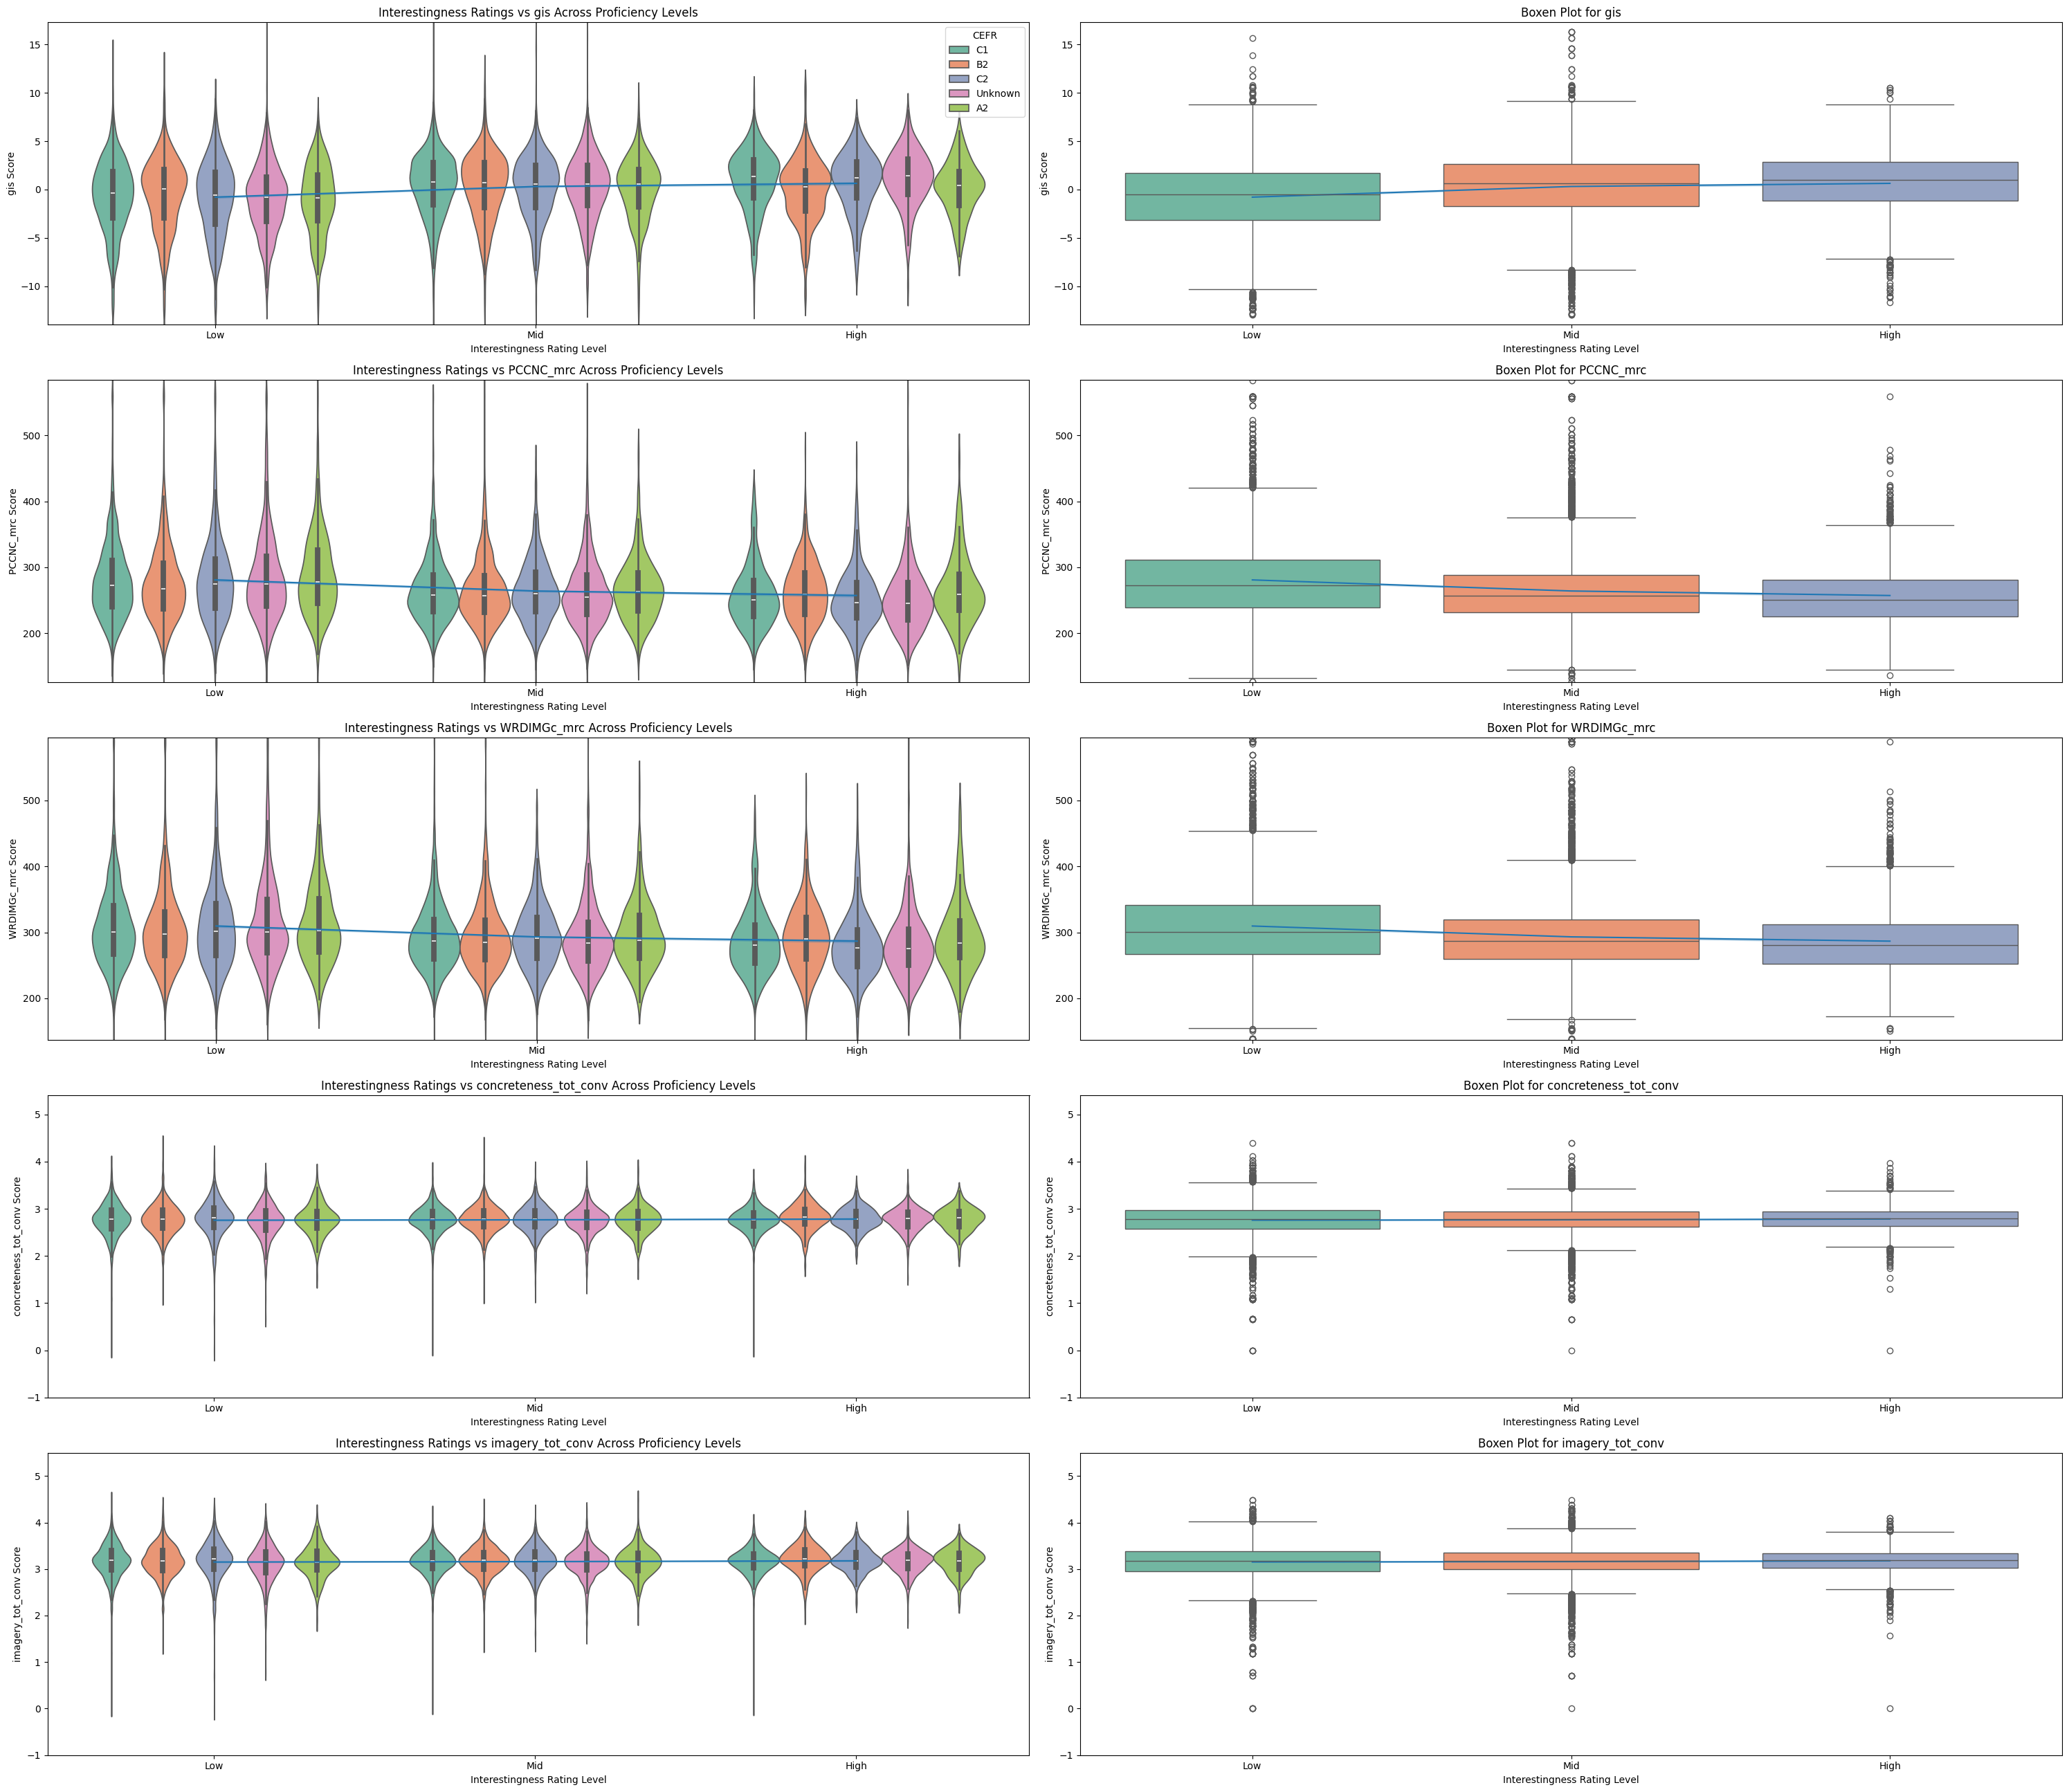

In [24]:

fig, axes = plt.subplots(5, 2, figsize=(30, 26))

# Define color palette
palette = sns.color_palette("Set2")

def create_plots(col_name, ax_violin, ax_box, show_legend=False):
    int_col = 'value'
    high_int = merge_df[merge_df[int_col] > 3]
    low_int = merge_df[merge_df[int_col] < 2]
    mid_int = merge_df[(merge_df[int_col] >= 2) & (merge_df[int_col] <= 3)]

    # Assign intensity level
    high_int['int_level'] = 'High'
    low_int['int_level'] = 'Low'
    mid_int['int_level'] = 'Mid'

    # Concatenate the dataframes
    combined_data = pd.concat([high_int, low_int, mid_int])

    # Plot 1: Violin plot with KDE smoothing

    sns.violinplot(x='int_level', y=col_name, data=combined_data, order=['Low', 'Mid', 'High'], hue='CEFR', ax=ax_violin, palette=palette)
    sns.lineplot(x='int_level', y=col_name, data=combined_data, legend=False, ax=ax_violin)
    ax_violin.set_title(f'Interestingness Ratings vs {col_name} Across Proficiency Levels', fontsize=12)
    ax_violin.set_xlabel('Interestingness Rating Level', fontsize=10)
    ax_violin.set_ylabel(f'{col_name} Score', fontsize=10)
    ax_violin.set_ylim([combined_data[col_name].min() - 1, combined_data[col_name].max() + 1])
    
    # Optional: only show legend for the first plot
    if show_legend:
        ax_violin.legend(title="CEFR", loc='upper right')
    else:
        ax_violin.get_legend().remove()

    # Plot 2: Boxen plot
    sns.boxplot(x='int_level', y=col_name, data=combined_data, order=['Low', 'Mid', 'High'], ax=ax_box, palette=palette)
    sns.lineplot(x='int_level', y=col_name, data=combined_data, legend=False, ax=ax_box)
    ax_box.set_title(f'Boxen Plot for {col_name}', fontsize=12)
    ax_box.set_xlabel('Interestingness Rating Level', fontsize=10)
    ax_box.set_ylabel(f'{col_name} Score', fontsize=10)
    ax_box.set_ylim([combined_data[col_name].min() - 1, combined_data[col_name].max() + 1])

# Create plots for 'gis'
create_plots('gis', axes[0, 0], axes[0, 1], show_legend=True)

# Create plots for 'PCCNC_mrc'
create_plots('PCCNC_mrc', axes[1, 0], axes[1, 1])

# Create plots for 'WRDIMGc_mrc'
create_plots('WRDIMGc_mrc', axes[2, 0], axes[2, 1])

# Create plots for 'WRDIMGc_mrc'
create_plots('concreteness_tot_conv', axes[3, 0], axes[3, 1])

# Create plots for 'WRDIMGc_mrc'
create_plots('imagery_tot_conv', axes[4, 0], axes[4, 1])

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [25]:
def compute_pval(col_name, merge_df):
    int_col = 'value'
    high_int = merge_df[merge_df[int_col] > 3]
    low_int = merge_df[merge_df[int_col] < 2]
    mid_int = merge_df[(merge_df[int_col] >= 2) & (merge_df[int_col] <= 3)]

    # Assign intensity level
    high_int['int_level'] = 'High'
    low_int['int_level'] = 'Low'
    mid_int['int_level'] = 'Mid'

    # Concatenate the dataframes
    combined_data = pd.concat([high_int, low_int, mid_int])

    # Group 'gis' scores by 'int_level'
    grouped_data = combined_data.groupby('int_level')[col_name].apply(list)

    # Perform ANOVA test
    f_statistic, p_value = stats.f_oneway(*grouped_data)


    print("F-statistic:", f_statistic)
    print("P-value:", p_value)

    # Calculate degrees of freedom
    numerator_df = len(grouped_data) - 1
    denominator_df = len(combined_data) - len(grouped_data)

    print("Degrees of Freedom (Numerator):", numerator_df)
    print("Degrees of Freedom (Denominator):", denominator_df)

    alpha = 0.05
    if p_value < alpha:
        print("Reject null hypothesis: There is a significant difference between intensity levels.")
    else:
        print("Fail to reject null hypothesis: There is no significant difference between intensity levels.")

In [26]:
compute_pval('gis', merge_df)

F-statistic: 254.34148399023442
P-value: 8.406625264837087e-110
Degrees of Freedom (Numerator): 2
Degrees of Freedom (Denominator): 19965
Reject null hypothesis: There is a significant difference between intensity levels.


In [27]:
compute_pval('PCCNC_mrc', merge_df)

F-statistic: 261.3091831389232
P-value: 9.435742945010295e-113
Degrees of Freedom (Numerator): 2
Degrees of Freedom (Denominator): 19965
Reject null hypothesis: There is a significant difference between intensity levels.


In [28]:
compute_pval('WRDIMGc_mrc', merge_df)

F-statistic: 230.2166164889264
P-value: 1.4244943649582762e-99
Degrees of Freedom (Numerator): 2
Degrees of Freedom (Denominator): 19965
Reject null hypothesis: There is a significant difference between intensity levels.


In [29]:
compute_pval('concreteness_tot_conv', merge_df)

F-statistic: nan
P-value: nan
Degrees of Freedom (Numerator): 2
Degrees of Freedom (Denominator): 19965
Fail to reject null hypothesis: There is no significant difference between intensity levels.


In [30]:
compute_pval('imagery_tot_conv', merge_df)

F-statistic: nan
P-value: nan
Degrees of Freedom (Numerator): 2
Degrees of Freedom (Denominator): 19965
Fail to reject null hypothesis: There is no significant difference between intensity levels.


In [44]:
combined_data.columns

Index(['conversation_id', 'id', 'PCCNC_mrc', 'WRDIMGc_mrc', 'gis', 'text',
       'human_int_mean', 'human_int_var', 'mis_nonchat_int', 'mix_int',
       'mis7_int', 'gpt4_int', 'gpt4o_int', '7b_int', '13b_int',
       '7bnonchat_int', '13bnonchat_int', 'llama3_chat_int',
       'llama3_nonchat_int', 'Participant', 'value', 'CEFR',
       'concreteness_tot_conv', 'imagery_tot_conv', 'int_level'],
      dtype='object')

In [47]:
df = combined_data[['PCCNC_mrc', 'WRDIMGc_mrc', 'gis', 'CEFR','int_level' ,'value']]
df

,PCCNC_mrc,WRDIMGc_mrc,gis,CEFR,int_level,value
23,251.454545,286.590909,0.360190,C1,High,4.0
407,319.368421,339.473684,3.650258,C1,High,4.0
599,235.461538,269.923077,0.013873,C1,High,4.0
695,247.904762,272.468254,2.839008,C1,High,4.0
714,247.904762,272.468254,2.839008,C1,High,4.0
...,...,...,...,...,...,...
638741,257.944444,282.555556,-0.889872,C1,Mid,3.0
638869,217.241935,252.403226,3.891937,A2,Mid,2.0
638899,207.861111,239.097222,6.795451,C1,Mid,3.0
638960,207.861111,239.097222,6.795451,C1,Mid,3.0


In [74]:
df['gis_round'] = df['gis'].apply(lambda x: round(x, 3))
df

,PCCNC_mrc,WRDIMGc_mrc,gis,CEFR,int_level,value,gis_round
23,251.454545,286.590909,0.360190,C1,High,4.0,0.360
407,319.368421,339.473684,3.650258,C1,High,4.0,3.650
599,235.461538,269.923077,0.013873,C1,High,4.0,0.014
695,247.904762,272.468254,2.839008,C1,High,4.0,2.839
714,247.904762,272.468254,2.839008,C1,High,4.0,2.839
...,...,...,...,...,...,...,...
638741,257.944444,282.555556,-0.889872,C1,Mid,3.0,-0.890
638869,217.241935,252.403226,3.891937,A2,Mid,2.0,3.892
638899,207.861111,239.097222,6.795451,C1,Mid,3.0,6.795
638960,207.861111,239.097222,6.795451,C1,Mid,3.0,6.795


In [117]:
df[df['gis_round']>7]['CEFR'].value_counts(normalize=True), df[df['gis_round']<3]['CEFR'].value_counts(normalize=True)

(CEFR
 C1         0.386667
 B2         0.271111
 Unknown    0.217778
 C2         0.111111
 A2         0.013333
 Name: proportion, dtype: float64,
 CEFR
 C1         0.368372
 Unknown    0.254757
 B2         0.215161
 C2         0.129934
 A2         0.031775
 Name: proportion, dtype: float64)

In [54]:
df['CEFR'].unique()

array(['C1', 'B2', 'C2', 'Unknown', 'A2'], dtype=object)

In [50]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

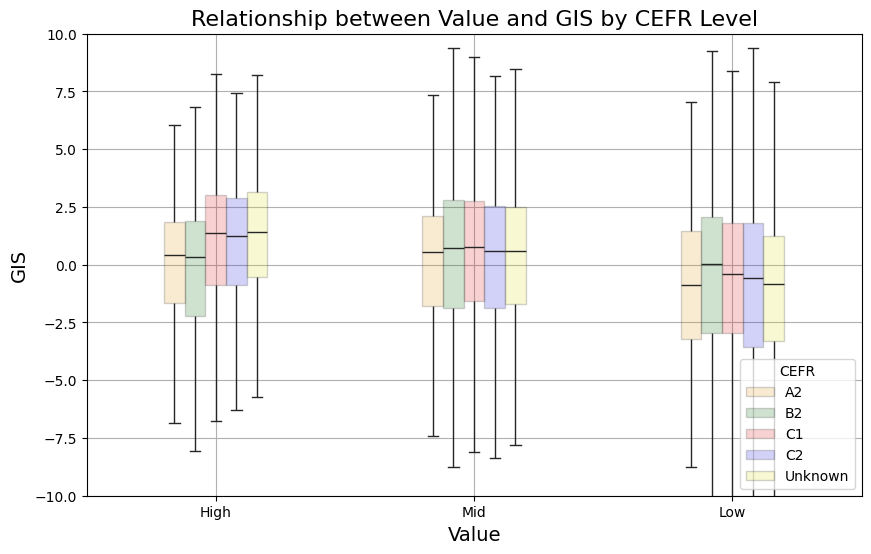

In [100]:
# Set up colors and markers for different CEFR levels
colors = {'C1': 'red', 'B2': 'green', 'C2': 'blue', 'A2': 'orange', 'Unknown':'yellow'}

# Define hue order for CEFR levels
hue_order = ['A2', 'B2', 'C1', 'C2', 'Unknown']
int_level_order = ['High', 'Mid', 'Low']
# Plot
plt.figure(figsize=(10, 6))

# Plot boxplots for each value grouped by CEFR levels, with colors corresponding to CEFR levels
g = sns.boxplot(x='int_level', y='gis_round', hue='CEFR', data=df, palette=colors, showfliers=False, width=0.4, 
            boxprops=dict(alpha=0.2),hue_order=hue_order,order=int_level_order)



# Customize plot
plt.title('Relationship between Value and GIS by CEFR Level', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('GIS', fontsize=14)
plt.ylim([-10, 10])  # Zoom in on Y-axis to focus on important values


# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

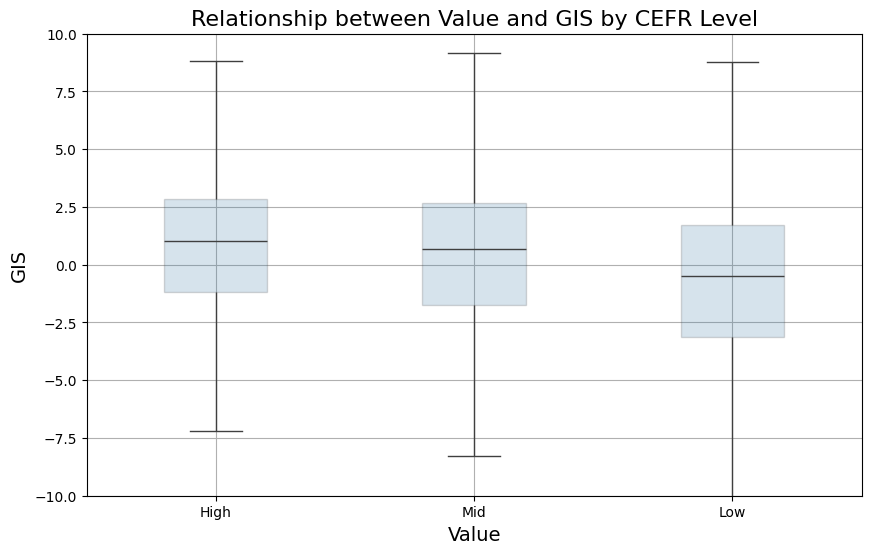

In [114]:
# Set up colors and markers for different CEFR levels
colors = {'C1': 'red', 'B2': 'green', 'C2': 'blue', 'A2': 'orange', 'Unknown':'yellow'}

# Define hue order for CEFR levels
hue_order = ['A2', 'B2', 'C1', 'C2', 'Unknown']
int_level_order = ['High', 'Mid', 'Low']
# Plot
plt.figure(figsize=(10, 6))

# Plot boxplots for each value grouped by CEFR levels, with colors corresponding to CEFR levels
g = sns.boxplot(x='int_level', y='gis_round',  data=df,  showfliers=False, width=0.4, 
            boxprops=dict(alpha=0.2),order=int_level_order)



# Customize plot
plt.title('Relationship between Value and GIS by CEFR Level', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('GIS', fontsize=14)
plt.ylim([-10, 10])  # Zoom in on Y-axis to focus on important values


# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

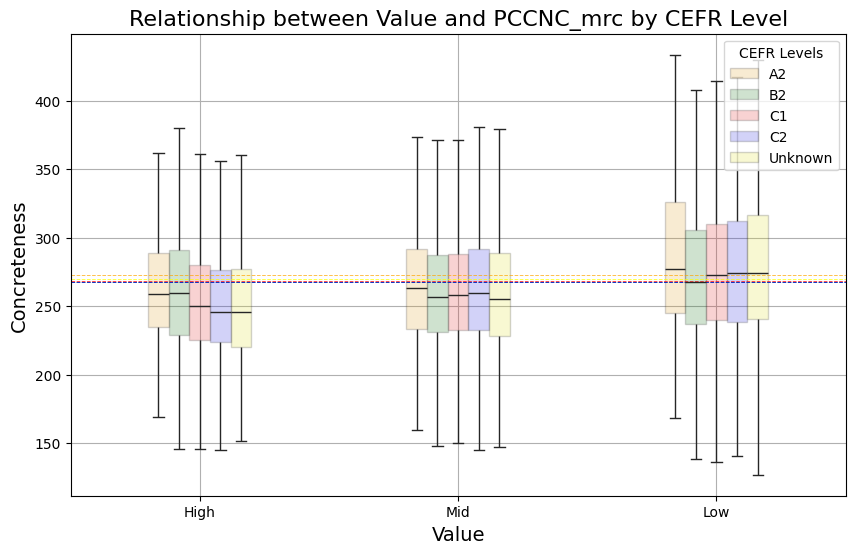

In [113]:
# Set up colors and markers for different CEFR levels
colors = {'C1': 'red', 'B2': 'green', 'C2': 'blue', 'A2': 'orange', 'Unknown': 'yellow'}

# Define hue order for CEFR levels and interaction levels
hue_order = ['A2', 'B2', 'C1', 'C2', 'Unknown']
int_level_order = ['High', 'Mid', 'Low']

# Calculate the average GIS values for each CEFR level to add a horizontal line
average_gis_by_cefr = df.groupby('CEFR')['PCCNC_mrc'].mean()

# Create the figure
plt.figure(figsize=(10, 6))

# Plot boxplots for each value grouped by CEFR levels, with colors corresponding to CEFR levels
g = sns.boxplot(x='int_level', y='PCCNC_mrc', hue='CEFR', data=df, palette=colors, showfliers=False, 
                width=0.4, boxprops=dict(alpha=0.2), hue_order=hue_order, order=int_level_order)

# Plot dotted lines for each CEFR level
for level in hue_order:
    plt.axhline(y=average_gis_by_cefr[level], color=colors[level], linestyle='--', alpha=0.7,linewidth=0.7)

# Customize plot
plt.title('Relationship between Value and PCCNC_mrc by CEFR Level', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Concret', fontsize=14)


# Add a grid for better readability
plt.grid(True)

# Add legend for the dotted lines
plt.legend(title="CEFR Levels", loc='upper right')

# Show the plot
plt.show()


In [ ]:
# Set up colors and markers for different CEFR levels
colors = {'C1': 'red', 'B2': 'green', 'C2': 'blue', 'A2': 'orange', 'Unknown': 'yellow'}

# Define hue order for CEFR levels and interaction levels
hue_order = ['A2', 'B2', 'C1', 'C2', 'Unknown']
int_level_order = ['High', 'Mid', 'Low']

# Calculate the average GIS values for each CEFR level to add a horizontal line
average_gis_by_cefr = df.groupby('CEFR')['gis_round'].mean()

# Create the figure
plt.figure(figsize=(10, 6))

# Plot boxplots for each value grouped by CEFR levels, with colors corresponding to CEFR levels
g = sns.boxplot(x='int_level', y='gis_round', hue='CEFR', data=df, palette=colors, showfliers=False, 
                width=0.4, boxprops=dict(alpha=0.2), hue_order=hue_order, order=int_level_order)

# Plot dotted lines for each CEFR level
for level in hue_order:
    plt.axhline(y=average_gis_by_cefr[level], color=colors[level], linestyle='--', alpha=0.5)

# Customize plot
plt.title('Relationship between Value and GIS by CEFR Level', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('GIS', fontsize=14)
plt.ylim([-10, 10])  # Zoom in on Y-axis to focus on important values

# Add a grid for better readability
plt.grid(True)

# Add legend for the dotted lines
plt.legend(title="CEFR Levels", loc='upper right')

# Show the plot
plt.show()


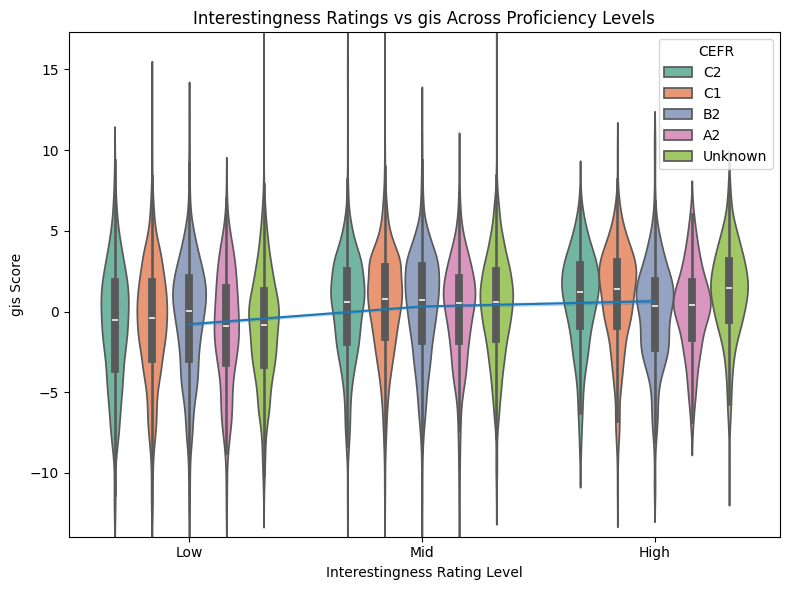

In [42]:

col_name = 'gis'
int_col = 'value'

high_int = merge_df[merge_df[int_col] > 3]
low_int = merge_df[merge_df[int_col] < 2]
mid_int = merge_df[(merge_df[int_col] >= 2) & (merge_df[int_col] <= 3)]

# Assign intensity level
high_int['int_level'] = 'High'
low_int['int_level'] = 'Low'
mid_int['int_level'] = 'Mid'

# Concatenate the dataframes
combined_data = pd.concat([high_int, low_int, mid_int])
hue_order = ['C2', 'C1', 'B2', 'A2', 'Unknown'] 
# Create a figure with subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# Plot 1: Violin plot with KDE smoothing
sns.violinplot(x='int_level', y=col_name, data=combined_data, order=['Low', 'Mid', 'High'], 
               hue='CEFR', hue_order=hue_order, ax=axes, palette=palette)

# Optional line plot overlay
sns.lineplot(x='int_level', y=col_name, data=combined_data, legend=False, ax=axes)

# Set titles and labels
axes.set_title(f'Interestingness Ratings vs {col_name} Across Proficiency Levels', fontsize=12)
axes.set_xlabel('Interestingness Rating Level', fontsize=10)
axes.set_ylabel(f'{col_name} Score', fontsize=10)
axes.set_ylim([combined_data[col_name].min() - 1, combined_data[col_name].max() + 1])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Gispy with LLM Ratings

In [31]:
gis_llms = gispy_merged[['conversation_id', 'id', 'human_int_mean', 'human_int_var', 'PCCNC_mrc', 'WRDIMGc_mrc', 'gis']].merge(all_llm_scores.drop(columns='proc_text'), on=['conversation_id', 'id'])
gis_llms

,conversation_id,id,human_int_mean,human_int_var,PCCNC_mrc,WRDIMGc_mrc,gis,mis_nonchat_int,mix_int,mis7_int,gpt4_int,gpt4o_int,7b_int,13b_int,7bnonchat_int,13bnonchat_int,llama3_chat_int,llama3_nonchat_int
0,7,45939,1.000000,1.000000,339.875000,371.375000,-2.447473,1.0,3,3.0,2.0,1,1.0,4.0,0,2,4,2.0
1,7,45940,1.333333,0.333333,300.653846,323.423077,1.963340,3.0,3,3.0,3.0,2,3.0,4.0,1,2,3,0.0
2,7,45941,2.000000,0.000000,251.064516,284.408602,2.118316,2.0,3,3.0,3.0,3,2.0,3.0,3,2,4,1.0
3,7,45942,2.666667,0.333333,266.061224,292.622449,2.944282,2.0,3,4.0,3.0,4,3.0,4.0,3,4,3,3.0
4,7,45943,2.000000,1.000000,225.444444,255.022222,3.711383,2.0,3,3.0,3.0,2,4.0,4.0,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6651,258,56386,1.000000,0.000000,307.117647,351.588235,-1.219117,1.0,2,2.0,2.0,1,4.0,3.0,2,1,2,4.0
6652,258,56387,1.333333,0.333333,215.580645,239.000000,3.425822,0.0,3,3.0,3.0,3,3.0,2.0,3,1,3,3.0
6653,258,56388,1.000000,1.000000,282.714286,339.809524,2.034560,4.0,2,0.0,2.0,2,4.0,3.0,3,0,1,2.0
6654,258,56389,0.666667,0.333333,287.214286,307.142857,-5.344408,2.0,1,0.0,2.0,1,4.0,NaN,3,2,0,3.0


In [32]:
corr3 = gis_llms.drop(columns=[ 'conversation_id', 'id', ]).corr(method='kendall')

# Style the correlation matrix with a background gradient
corr3.style.background_gradient(cmap='coolwarm')

,human_int_mean,human_int_var,PCCNC_mrc,WRDIMGc_mrc,gis,mis_nonchat_int,mix_int,mis7_int,gpt4_int,gpt4o_int,7b_int,13b_int,7bnonchat_int,13bnonchat_int,llama3_chat_int,llama3_nonchat_int
human_int_mean,1.000000,0.000098,-0.162948,-0.153531,0.175621,0.009001,0.236203,0.074737,0.140488,0.239681,-0.002394,0.010599,0.084221,0.042300,0.133183,-0.002226
human_int_var,0.000098,1.000000,0.005611,0.005962,-0.010067,0.013877,-0.033708,0.001015,-0.001863,-0.041684,0.023580,-0.007018,-0.013180,-0.008355,-0.043717,-0.010776
PCCNC_mrc,-0.162948,0.005611,1.000000,0.807538,-0.308924,-0.020064,-0.185620,-0.086039,-0.179327,-0.185443,-0.044406,-0.024264,-0.083473,-0.024832,-0.104748,-0.001610
WRDIMGc_mrc,-0.153531,0.005962,0.807538,1.000000,-0.290830,-0.013006,-0.173630,-0.077686,-0.163583,-0.167281,-0.037080,-0.019283,-0.075723,-0.024602,-0.095347,0.002674
gis,0.175621,-0.010067,-0.308924,-0.290830,1.000000,0.004221,0.190790,0.084215,0.200132,0.192433,0.028277,0.005735,0.064492,0.020546,0.097733,0.004165
mis_nonchat_int,0.009001,0.013877,-0.020064,-0.013006,0.004221,1.000000,0.018379,-0.001922,0.003613,0.018381,0.001033,0.016569,0.037908,0.032040,0.022650,0.006840
mix_int,0.236203,-0.033708,-0.185620,-0.173630,0.190790,0.018379,1.000000,0.145552,0.248493,0.389306,0.044905,0.055506,0.076112,0.032115,0.255386,0.015422
mis7_int,0.074737,0.001015,-0.086039,-0.077686,0.084215,-0.001922,0.145552,1.000000,0.106243,0.143612,-0.000316,0.010198,0.014591,-0.006188,0.098481,0.019895
gpt4_int,0.140488,-0.001863,-0.179327,-0.163583,0.200132,0.003613,0.248493,0.106243,1.000000,0.270036,0.037513,0.038139,0.058703,0.011430,0.140788,0.014638
gpt4o_int,0.239681,-0.041684,-0.185443,-0.167281,0.192433,0.018381,0.389306,0.143612,0.270036,1.000000,0.061807,0.047993,0.105663,0.019461,0.303445,0.018011


## Comprehensibility

In [33]:
complexity = pd.read_excel('data/readbility_metrics.xlsx')
complexity

,proc_text,conversation_id,id,int_mean,int_var,flesch_reading_ease,flesch_kincaid_grade,smog_index,coleman_liau_index,automated_readability_index,dale_chall_readability_score,spache_readability,syllable_count,lexicon_count,difficult_words,gunning_fog,linsear_write_formula,mcalpine_eflaw,text_standard
0,"hi <teacher>, how are you? yeah i'm good th...",7,53285,3.000000,1.000000,98.92,1.0,6.0,1.74,1.9,7.11,2.75,30,25,3,4.12,2.375000,9.5,2
1,yeah well my daughter started doing it and ha...,7,45947,1.666667,0.333333,89.79,4.5,6.4,3.70,4.6,6.11,3.37,57,46,2,6.12,7.166667,24.0,5
2,yeah? in the uk too i'd say....there are lots...,7,45955,1.666667,0.333333,82.65,5.2,9.5,4.28,4.8,7.71,3.43,71,56,4,7.74,7.375000,21.5,8
3,yeah? what did you do? i'll come back on the ...,7,45941,2.000000,0.000000,83.05,5.1,8.1,4.34,4.1,6.92,3.79,139,109,13,6.91,5.875000,20.8,6
4,great but not 'as a team' just for yourself...,7,53297,2.000000,4.000000,69.28,6.2,0.0,5.83,5.1,7.16,3.14,31,21,2,6.10,5.750000,15.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6651,"but then, if you have some exercises or inter...",258,38329,2.333333,1.333333,63.22,10.6,11.7,7.14,11.5,7.58,5.54,139,99,14,12.75,14.750000,36.8,8
6652,my guess is that in italian 'borrow' and 'len...,258,56381,1.666667,1.333333,75.24,8.1,9.7,7.08,10.0,7.65,4.92,83,64,8,9.15,12.166667,30.0,10
6653,nearly! had ___ up in another time they are...,258,56382,1.666667,1.333333,88.06,5.2,0.0,3.25,5.2,6.80,3.74,41,34,2,7.98,8.500000,26.5,6
6654,maybe i should start by writing a topic sente...,258,38323,2.333333,2.333333,74.19,6.4,9.4,8.87,8.7,8.62,4.29,98,70,12,8.46,7.400000,19.2,9


In [34]:
human_ratings_individuals

,text,conversation_id,id,human_int_mean,human_int_var,58c62eac444ade00010231a9,59b536d60516f6000197c3f9,5ab15ab4c42b630001cd36fb,5ad63c167f70c10001904bc5,5b830542b0d72600018dc280,...,61139bc8479c2861f52c4a71,611a78efa6c36a674dc40cc6,611a9f9591ef82d19cfc5db1,611ccab657532350bc9b78ee,612a87998958706392797405,613d091096ca434d703f77c5,614e848825ae648282115670,61693c754827d0e35885a4ea,6171b1bc917dfe828a3130dd,6341258618bd26e47d901d74
0,"teacher: hi there <student>, all ok? student:...",7,45939,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"teacher: yeah i'm good thanks, just been for a...",7,45940,1.333333,0.333333,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,teacher: yeah? what did you do? i'll come back...,7,45941,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,teacher: ok i see ...too bad about the running...,7,45942,2.666667,0.333333,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,teacher: yes i realise it's not easy really! i...,7,45943,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6651,teacher: but 'to loan' means 'to lend' studen...,258,56386,1.000000,0.000000,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6652,"teacher: banks loan money yes, exactly, it wou...",258,56387,1.333333,0.333333,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6653,"teacher: ooh, we're out of time! student: or ...",258,56388,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6654,"teacher: yes, absolutely! student: 13:59 on m...",258,56389,0.666667,0.333333,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
complexity.merge(human_ratings_individuals, on=['conversation_id', 'id'], how='left')

,proc_text,conversation_id,id,int_mean,int_var,flesch_reading_ease,flesch_kincaid_grade,smog_index,coleman_liau_index,automated_readability_index,...,61139bc8479c2861f52c4a71,611a78efa6c36a674dc40cc6,611a9f9591ef82d19cfc5db1,611ccab657532350bc9b78ee,612a87998958706392797405,613d091096ca434d703f77c5,614e848825ae648282115670,61693c754827d0e35885a4ea,6171b1bc917dfe828a3130dd,6341258618bd26e47d901d74
0,"hi <teacher>, how are you? yeah i'm good th...",7,53285,3.000000,1.000000,98.92,1.0,6.0,1.74,1.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,yeah well my daughter started doing it and ha...,7,45947,1.666667,0.333333,89.79,4.5,6.4,3.70,4.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,yeah? in the uk too i'd say....there are lots...,7,45955,1.666667,0.333333,82.65,5.2,9.5,4.28,4.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,yeah? what did you do? i'll come back on the ...,7,45941,2.000000,0.000000,83.05,5.1,8.1,4.34,4.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,great but not 'as a team' just for yourself...,7,53297,2.000000,4.000000,69.28,6.2,0.0,5.83,5.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6651,"but then, if you have some exercises or inter...",258,38329,2.333333,1.333333,63.22,10.6,11.7,7.14,11.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6652,my guess is that in italian 'borrow' and 'len...,258,56381,1.666667,1.333333,75.24,8.1,9.7,7.08,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6653,nearly! had ___ up in another time they are...,258,56382,1.666667,1.333333,88.06,5.2,0.0,3.25,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6654,maybe i should start by writing a topic sente...,258,38323,2.333333,2.333333,74.19,6.4,9.4,8.87,8.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
